<a href="https://colab.research.google.com/github/nicolegold/AnalistaMachineLearning/blob/master/PrevisaoDeVendas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Biblioteca para importar o banco de dados
from google.colab import files
uploaded = files.upload()

Saving airline-passengers.csv to airline-passengers.csv


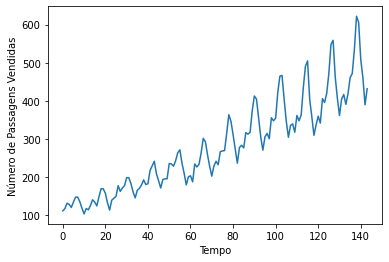

In [2]:
import pandas #utilizada para tratar os dataframes
import matplotlib.pyplot as plt  # utilizada para criar os gráficos
dataset = pandas.read_csv('airline-passengers.csv', usecols=[1], engine='python') #lê o banco de dados dos passageiros
plt.plot(dataset)  #realiza o plot do gráfico
plt.xlabel("Tempo")
plt.ylabel("Número de Passagens Vendidas")
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


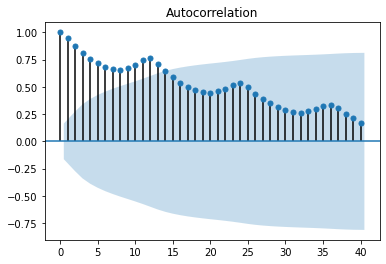

In [3]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(dataset.values.squeeze(), lags=40)
plt.show()

In [4]:
#bibliotecas utilizadas para a construção dos modelos de previsão de vendas de passagens
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [0]:
# normalizzação do banco de dados, necessário para que os algoritmos possam ter um comportamento mais "previsível"
scaler = MinMaxScaler(feature_range=(0, 1)) #cria o objeto que realiza a normalização dos dados por meio dos valores mínimos e máximos
dataset = scaler.fit_transform(dataset) # aplica a escala

In [6]:
# Divide o conjunto de dados em treinamento e teste 
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [0]:
#Cria a matriz necessária para a entrada de dados 
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [0]:
#cria o reshape para que os dados estejam em um formato ideal para entrada
look_back = 1  # será utilizado apenas um passo anterior para a previsão do futuro
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [0]:
# cria o modelo utilizando redes recorrentes e o LSTM
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [10]:
#realiza o treinamento o modelo de previsão
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 1s - loss: 0.0498
Epoch 2/100
 - 0s - loss: 0.0260
Epoch 3/100
 - 0s - loss: 0.0178
Epoch 4/100
 - 0s - loss: 0.0159
Epoch 5/100
 - 0s - loss: 0.0151
Epoch 6/100
 - 0s - loss: 0.0142
Epoch 7/100
 - 0s - loss: 0.0133
Epoch 8/100
 - 0s - loss: 0.0125
Epoch 9/100
 - 0s - loss: 0.0114
Epoch 10/100
 - 0s - loss: 0.0105
Epoch 11/100
 - 0s - loss: 0.0094
Epoch 12/100
 - 0s - loss: 0.0085
Epoch 13/100
 - 0s - loss: 0.0074
Epoch 14/100
 - 0s - loss: 0.0065
Epoch 15/100
 - 0s - loss: 0.0057
Epoch 16/100
 - 0s - loss: 0.0048
Epoch 17/100
 - 0s - loss: 0.0042
Epoch 18/100
 - 0s - loss: 0.0036
Epoch 19/100
 - 0s - loss: 0.0031
Epoch 20/100
 - 0s - loss: 0.0028
Epoch 21/100
 - 0s - loss: 0.0025
Epoch 22/100
 - 0s - loss: 0.0023
Epoch 23/100
 - 0s - loss: 0.0022
Epoch 24/100
 - 0s - loss: 0.0021
Epoch 25/100
 - 0s - loss: 0.0021
Epoch 26/100
 - 0s - loss: 0.0020
Epoch 27/100
 - 0s - loss: 0.0020
Epoch 28/100
 - 0s - loss: 0.0020
Epoch 29/100
 - 0s - loss: 0.0020
Epoch 30/100
 - 0s - lo

In [0]:
# realiza as previsões
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


In [0]:
# coloca os dados no formato original
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


In [13]:
# Calcula o MSE 
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score de Treinamento: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score de Teste: %.2f RMSE' % (testScore))

Score de Treinamento: 22.91 RMSE
Score de Teste: 52.88 RMSE


In [0]:
# Realiza a mudança dos dados para a previsão
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
#shift para os dados de teste
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

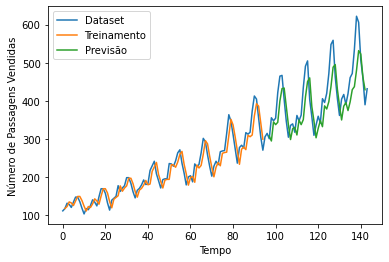

In [15]:
# Realiza o plot dos dados de previsão e o real
plt.plot(scaler.inverse_transform(dataset),label='Dataset')
plt.plot(trainPredictPlot, label='Treinamento')
plt.plot(testPredictPlot,label='Previsão')
plt.xlabel("Tempo")
plt.ylabel("Número de Passagens Vendidas")
plt.legend()
plt.show()